In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hr
import dionysus as d
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.tda import ClutchMapper, visualize_complex
from src.data_pipeline import query_avg, query_week
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pickle

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

plt.style.use('ggplot')

init_notebook_mode(connected=True)

In [2]:
df = query_avg("HAVING position = 'QB'")

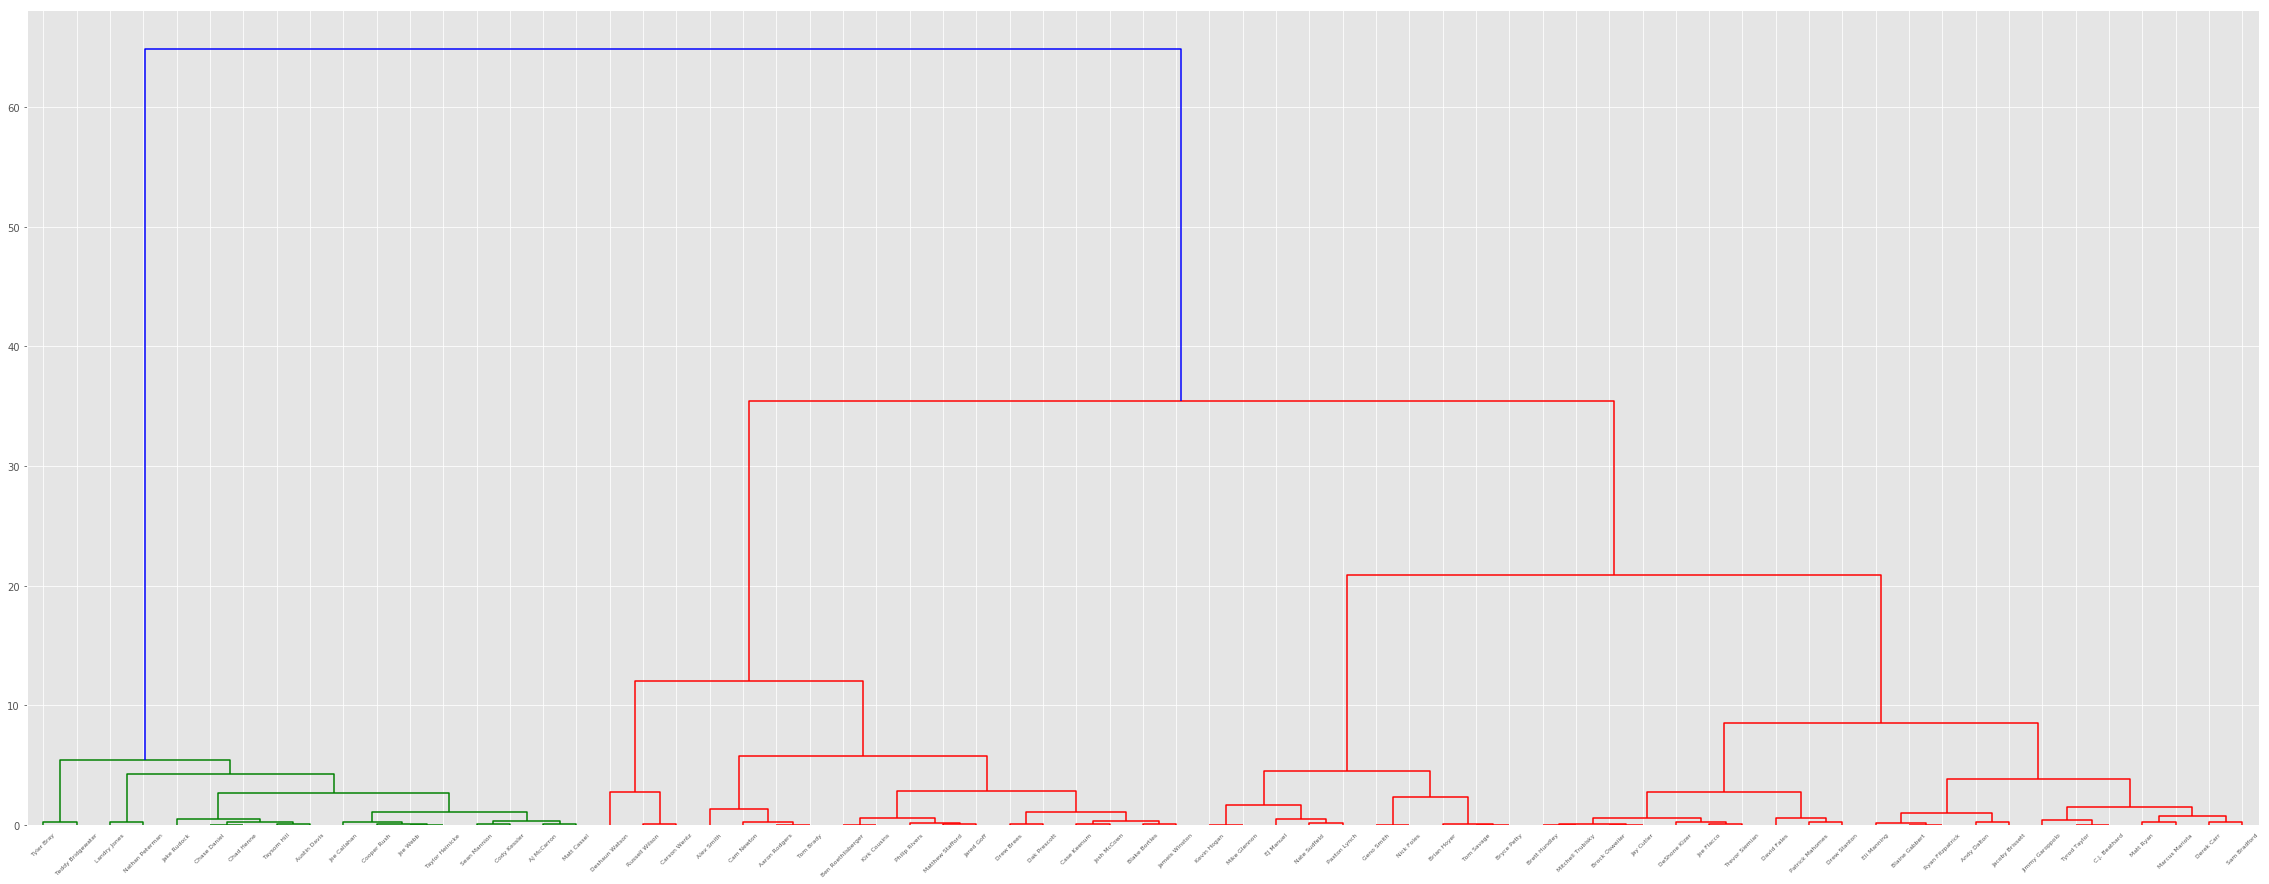

In [3]:
X = df['avg_points'].values.reshape(-1,1)
dist_vector = pdist(X, metric='euclidean')
linkage_mat = hr.linkage(dist_vector, method='ward')
plt.figure(figsize=(40,15));
dendrogram = hr.dendrogram(linkage_mat, labels=df['name'].values);
plt.xticks(rotation=45);
plt.savefig('../plots/dendrogram_ward_linkage_qb')

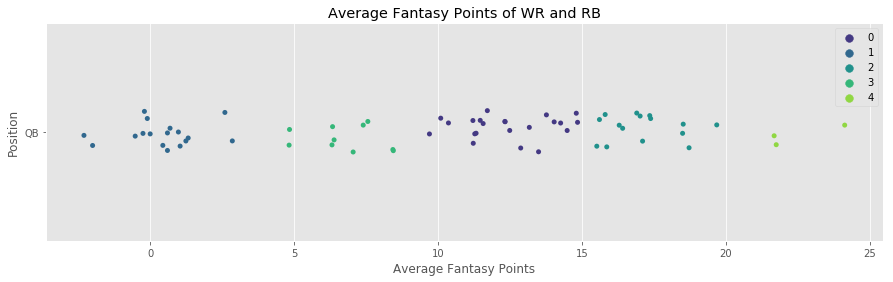

In [4]:
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = agg.fit_predict(X)

plt.figure(figsize=(15,4));
plt.title('Average Fantasy Points of WR and RB');
sns.stripplot(x="avg_points", y="pos", data=df, hue=labels, palette='viridis', jitter=True);
plt.xlabel('Average Fantasy Points');
plt.ylabel('Position');

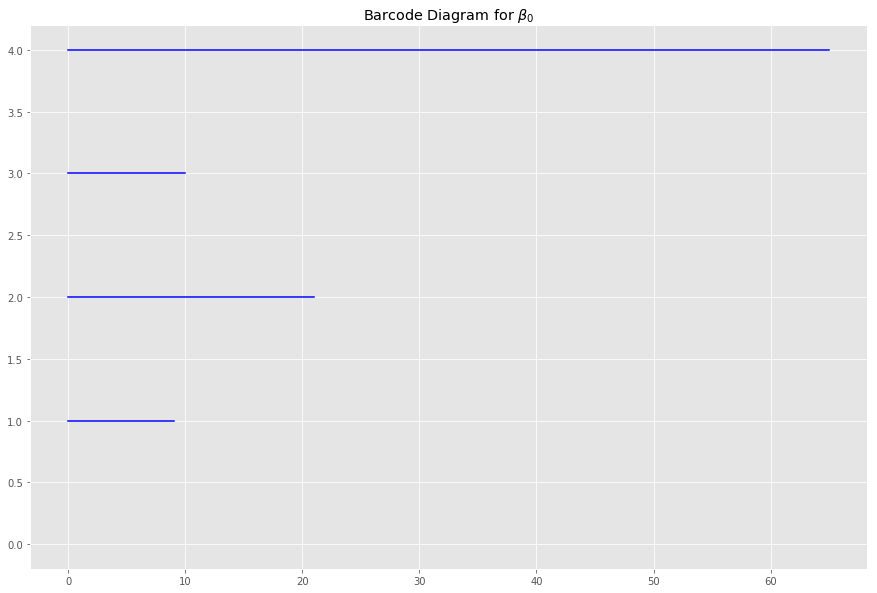

In [5]:
stats = df.iloc[:,4:].values

scaler = StandardScaler()
scaled_stats = scaler.fit_transform(stats)

cmapper = ClutchMapper()
cmapper.fit(scaled_stats, labels)

f = cmapper.build_filtration()

ph = d.homology_persistence(f)
dgms = d.init_diagrams(ph, f)

plt.figure(figsize=(15,10));
plt.title('Barcode Diagram for $\\beta_0$');
d.plot.plot_bars(dgms[0], show = True)

In [10]:
qb_complex = cmapper.build_complex(38)

fig = visualize_complex(qb_complex, 'QB Complex')
iplot(fig, filename='qb_complex')

In [12]:
df['label'] = labels

col_list = ['name']

for col in df.columns[3:]:
    if df[col].max() > 0:
        col_list.append(col)

In [13]:
df.loc[df['label'] == 4, col_list]

,name,avg_points,avg_passing_attempts,avg_passing_completions,avg_incomplete_passes,avg_passing_yards,avg_passing_touchdowns,avg_interceptions_thrown,avg_every_time_sacked,avg_rushing_attempts,avg_rushing_yards,avg_rushing_touchdowns,avg_receptions,avg_receiving_yards,avg_fumbles_lost,avg_fumble,avg_2_point_conversions,avg_tackle,avg_assisted_tackles,avg_forced_fumble,avg_fumbles_recovery,label
0,Deshaun Watson,24.122857,29.142857,18.000000,11.142857,242.714286,2.714286,1.142857,2.714286,5.142857,38.428571,0.285714,0.0,0.0,0.142857,0.428571,0.285714,0.285714,0.0,0.0000,0.000000,4
1,Russell Wilson,21.745000,34.562500,21.187500,13.375000,248.937500,2.125000,0.687500,2.687500,5.937500,36.625000,0.187500,0.0,0.0,0.187500,0.875000,0.125000,0.187500,0.0,0.0625,0.375000,4
2,Carson Wentz,21.672308,33.846154,20.384615,13.461538,253.538462,2.538462,0.538462,2.153846,4.923077,23.000000,0.000000,0.0,0.0,0.230769,0.692308,0.307692,0.076923,0.0,0.0000,0.307692,4


In [14]:
df.loc[df['label'] == 2, col_list]

,name,avg_points,avg_passing_attempts,avg_passing_completions,avg_incomplete_passes,avg_passing_yards,avg_passing_touchdowns,avg_interceptions_thrown,avg_every_time_sacked,avg_rushing_attempts,avg_rushing_yards,avg_rushing_touchdowns,avg_receptions,avg_receiving_yards,avg_fumbles_lost,avg_fumble,avg_2_point_conversions,avg_tackle,avg_assisted_tackles,avg_forced_fumble,avg_fumbles_recovery,label
3,Alex Smith,19.678667,33.666667,22.733333,10.933333,269.466667,1.733333,0.333333,2.333333,4.000000,23.666667,0.066667,0.0,0.0,0.066667,0.133333,0.000000,0.133333,0.0000,0.000000,0.200000,2
4,Cam Newton,18.717500,30.750000,18.187500,12.562500,206.375000,1.375000,1.000000,2.187500,8.687500,47.125000,0.375000,0.0,0.0,0.062500,0.562500,0.062500,0.062500,0.0625,0.000000,0.187500,2
5,Aaron Rodgers,18.514286,34.000000,22.000000,12.000000,239.285714,2.285714,0.857143,3.142857,3.428571,18.000000,0.000000,0.0,0.0,0.142857,0.142857,0.000000,0.000000,0.0000,0.000000,0.142857,2
6,Tom Brady,18.492500,36.312500,24.062500,12.250000,286.062500,2.000000,0.500000,2.187500,1.562500,1.750000,0.000000,0.0,0.0,0.187500,0.437500,0.125000,0.000000,0.0000,0.000000,0.125000,2
7,Ben Roethlisberger,17.382667,37.400000,24.000000,13.400000,283.400000,1.866667,0.933333,1.400000,1.866667,3.133333,0.000000,0.0,0.0,0.066667,0.200000,0.133333,0.000000,0.0000,0.000000,0.133333,2
8,Kirk Cousins,17.351250,33.750000,21.687500,12.062500,255.812500,1.687500,0.812500,2.562500,3.062500,11.187500,0.250000,0.0,0.0,0.312500,0.812500,0.000000,0.062500,0.0000,0.000000,0.250000,2
9,Matthew Stafford,17.102500,35.312500,23.187500,12.125000,277.875000,1.812500,0.625000,2.937500,1.812500,6.125000,0.000000,0.0,0.0,0.437500,0.687500,0.125000,0.062500,0.0000,0.000000,0.125000,2
10,Jared Goff,17.017333,31.800000,19.733333,12.066667,253.600000,1.866667,0.466667,1.666667,1.866667,3.400000,0.066667,0.0,0.0,0.200000,0.533333,0.000000,0.066667,0.0000,0.000000,0.000000,2
11,Philip Rivers,16.900000,35.937500,22.500000,13.437500,282.187500,1.750000,0.625000,1.125000,1.125000,-0.125000,0.000000,0.0,0.0,0.062500,0.500000,0.000000,0.062500,0.0000,0.000000,0.312500,2
12,Drew Brees,16.410000,33.500000,24.125000,9.375000,270.875000,1.437500,0.500000,1.250000,2.062500,0.750000,0.125000,0.0,0.0,0.000000,0.312500,0.000000,0.062500,0.0000,0.000000,0.187500,2


In [15]:
df.loc[df['label'].isin([0,3]), col_list]

,name,avg_points,avg_passing_attempts,avg_passing_completions,avg_incomplete_passes,avg_passing_yards,avg_passing_touchdowns,avg_interceptions_thrown,avg_every_time_sacked,avg_rushing_attempts,avg_rushing_yards,avg_rushing_touchdowns,avg_receptions,avg_receiving_yards,avg_fumbles_lost,avg_fumble,avg_2_point_conversions,avg_tackle,avg_assisted_tackles,avg_forced_fumble,avg_fumbles_recovery,label
18,Tyrod Taylor,14.844000,28.000000,17.533333,10.466667,186.600000,0.933333,0.266667,3.066667,5.600000,28.466667,0.266667,0.000000,0.000000,0.133333,0.266667,0.000000,0.000000,0.0,0.0,0.000000,0
19,C.J. Beathard,14.800000,37.333333,20.500000,16.833333,238.333333,0.666667,1.000000,3.166667,4.333333,22.666667,0.500000,0.000000,0.000000,0.333333,0.500000,0.000000,0.166667,0.0,0.0,0.166667,0
20,Jimmy Garoppolo,14.483333,29.666667,20.000000,9.666667,260.000000,1.166667,0.833333,1.333333,2.500000,1.833333,0.166667,0.166667,-1.000000,0.000000,0.166667,0.000000,0.166667,0.0,0.0,0.166667,0
21,Matt Ryan,14.256250,33.062500,21.375000,11.687500,255.937500,1.250000,0.750000,1.500000,2.000000,8.937500,0.000000,0.000000,0.000000,0.187500,0.250000,0.000000,0.000000,0.0,0.0,0.062500,0
22,Marcus Mariota,14.032000,30.200000,18.733333,11.466667,215.466667,0.866667,1.000000,1.800000,4.000000,20.800000,0.333333,0.000000,0.000000,0.066667,0.133333,0.000000,0.133333,0.0,0.0,0.066667,0
23,Derek Carr,13.762667,34.333333,21.533333,12.800000,233.066667,1.466667,0.866667,1.333333,1.533333,4.400000,0.000000,0.000000,0.000000,0.200000,0.533333,0.133333,0.066667,0.0,0.0,0.066667,0
24,Sam Bradford,13.490000,21.500000,16.000000,5.500000,191.000000,1.500000,0.000000,2.500000,1.000000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0
25,Andy Dalton,13.168750,31.000000,18.562500,12.437500,207.500000,1.562500,0.750000,2.437500,2.375000,6.187500,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.125000,0.0,0.0,0.062500,0
26,Jacoby Brissett,12.870000,29.312500,17.250000,12.062500,193.625000,0.812500,0.437500,3.250000,3.937500,16.250000,0.250000,0.000000,0.000000,0.187500,0.500000,0.000000,0.000000,0.0,0.0,0.312500,0
27,Eli Manning,12.488000,38.066667,23.466667,14.600000,231.200000,1.266667,0.866667,2.066667,0.800000,1.733333,0.066667,0.000000,0.000000,0.333333,0.733333,0.000000,0.000000,0.0,0.0,0.333333,0


In [16]:
df.loc[df['label'] == 1, col_list]

,name,avg_points,avg_passing_attempts,avg_passing_completions,avg_incomplete_passes,avg_passing_yards,avg_passing_touchdowns,avg_interceptions_thrown,avg_every_time_sacked,avg_rushing_attempts,avg_rushing_yards,avg_rushing_touchdowns,avg_receptions,avg_receiving_yards,avg_fumbles_lost,avg_fumble,avg_2_point_conversions,avg_tackle,avg_assisted_tackles,avg_forced_fumble,avg_fumbles_recovery,label
50,Landry Jones,2.853333,9.333333,7.666667,1.666667,79.666667,0.333333,0.333333,1.00,2.666667,-3.333333,0.0,0.0,0.0,0.333333,0.333333,0.0,0.000000,0.0,0.0,1.0,1
51,Nathan Peterman,2.595000,12.250000,6.000000,6.250000,63.000000,0.500000,1.250000,0.25,1.750000,5.750000,0.0,0.0,0.0,0.000000,0.500000,0.0,0.000000,0.0,0.0,0.5,1
52,AJ McCarron,1.320000,7.000000,3.500000,3.500000,33.000000,0.000000,0.000000,0.50,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1
53,Matt Cassel,1.240000,21.000000,12.500000,8.500000,81.000000,0.500000,1.000000,4.00,0.000000,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.500000,0.0,0.0,0.0,1
54,Sean Mannion,1.040000,7.400000,4.400000,3.000000,37.000000,0.000000,0.000000,0.60,1.800000,-0.400000,0.0,0.0,0.0,0.200000,0.400000,0.0,0.000000,0.0,0.0,0.0,1
55,Cody Kessler,0.980000,7.666667,3.666667,4.000000,42.000000,0.000000,0.333333,2.00,0.333333,-0.333333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1
56,Cooper Rush,0.690000,1.500000,0.500000,1.000000,1.000000,0.000000,0.000000,0.00,1.000000,6.500000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1
57,Joe Webb,0.600000,0.875000,0.250000,0.625000,4.375000,0.000000,0.125000,0.00,1.000000,6.750000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.5,0.0,0.0,1
58,Taylor Heinicke,0.600000,1.000000,1.000000,0.000000,10.000000,0.000000,0.000000,1.00,1.000000,2.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1
59,Joe Callahan,0.440000,7.000000,5.000000,2.000000,11.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1


In [17]:
qb_wk1 = query_week()

In [18]:
X = qb_wk1['weekpts'].values.reshape(-1,1)

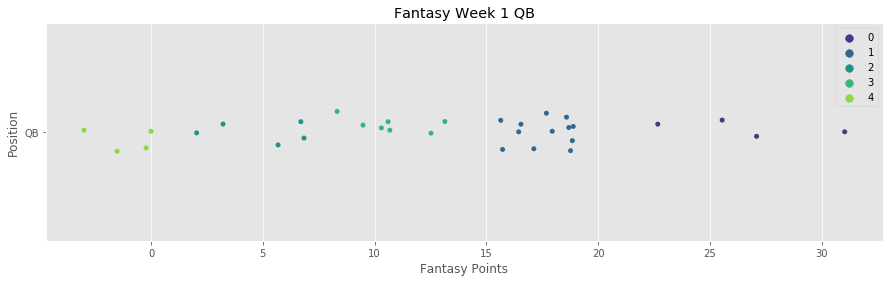

In [19]:
labels = agg.fit_predict(X)

plt.figure(figsize=(15,4));
plt.title('Fantasy Week 1 QB');
sns.stripplot(x="weekpts", y="pos", data=qb_wk1, hue=labels, palette='viridis', jitter=True);
plt.xlabel('Fantasy Points');
plt.ylabel('Position');

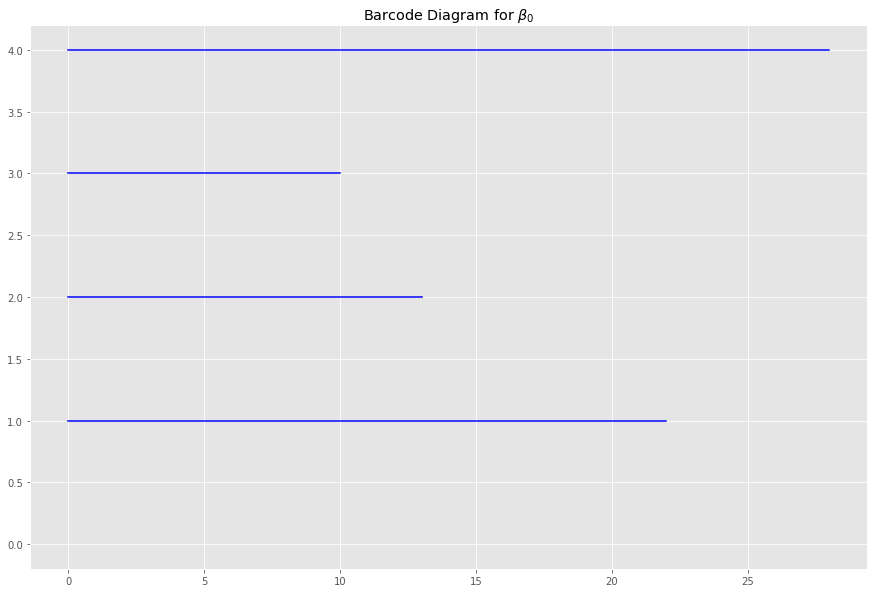

In [20]:
stats = qb_wk1.iloc[:,4:].values

scaler = MinMaxScaler()
scaled_stats = scaler.fit_transform(stats)

cmapper = ClutchMapper()
cmapper.fit(scaled_stats, labels)

f = cmapper.build_filtration()

ph = d.homology_persistence(f)
dgms = d.init_diagrams(ph, f)

plt.figure(figsize=(15,10));
plt.title('Barcode Diagram for $\\beta_0$');
d.plot.plot_bars(dgms[0], show = True)

In [21]:
qb_wk1_complex = cmapper.build_complex(20)

fig = visualize_complex(qb_wk1_complex, 'QB Week 1 Complex')
iplot(fig, filename='qb_wk1_complex')

In [22]:
fig_json = fig.to_plotly_json()

In [23]:
type(fig_json['data'][0]['marker']['color'][0])

int

In [ ]:
import json

with open('../data/simplicial_complex.pkl', 'w') as f:
    json.dump(fig_json, f)

In [ ]:
with open('../data/simplicial_complex.pkl', 'r') as f:
    simp = pickle.load(f)

In [ ]:
qb_wk1_complex

In [ ]:
qb_wk1['label'] = labels

col_list = ['name']

for col in qb_wk1.columns[3:]:
    if qb_wk1[col].max() > 0:
        col_list.append(col)

In [ ]:
qb_wk1.loc[qb_wk1['label'] == 4, col_list]

In [ ]:
qb_wk1.loc[qb_wk1['label'] == 0, col_list]

In [ ]:
qb_wk1.loc[qb_wk1['label'] == 2, col_list]

In [7]:
qb_wk1.loc[qb_wk1['label'].isin([1,3]), col_list]

NameError: name 'qb_wk1' is not defined